In [ ]:
#Title + short description
# Module 1 — Template/Test Preprocessing & ROI Extraction
This module implements:
1. grayscale conversion, optional resizing
2. template vs test absolute difference
3. Gaussian smoothing
4. Otsu thresholding
5. morphological closing & opening
6. contour detection and ROI cropping

Outputs:
- `selected_paths.json` (example template/test used)
- `data/rois/images/` will be created in Module 2
- Visualizations: template, test, diff, mask, and annotated ROIs


In [9]:
#Imports & config
#Imports and device config (Module 1)
import json
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to dataset root (update if necessary)
DATASET_ROOT = Path(r"C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET")
assert DATASET_ROOT.exists(), f"Dataset not found: {DATASET_ROOT}"


In [10]:
#Auto-detect pair + save selection
# Auto-detect example template/test pair and save to selected_paths.json
root = DATASET_ROOT
# prefer images/ and rotation/ folders if present
images_root = root / "images"
rotation_root = root / "rotation"
# Pick first example per earlier detection logic
template_path = next(images_root.rglob("*.[jJpP][pPnN][gG]"), None)
test_path     = next(rotation_root.rglob("*.[jJpP][pPnN][gG]"), None)
# fallback: any two images
if template_path is None or test_path is None:
    images = [p for p in root.rglob("*") if p.suffix.lower() in (".png",".jpg",".jpeg",".bmp",".tif",".tiff")]
    assert len(images) >= 2, "No image files found"
    template_path, test_path = images[0], images[1]
sel = {"template": str(template_path), "test": str(test_path)}
Path("selected_paths.json").write_text(json.dumps(sel, indent=2))
print("Selected template:", template_path)
print("Selected test    :", test_path)


Selected template: C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET\images\Missing_hole\01_missing_hole_01.jpg
Selected test    : C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET\rotation\Missing_hole_rotation\01_missing_hole_01.jpg


In [11]:
#Preprocessing function
def preprocess_and_subtract(template_path, test_path, resize_to=None, show=True):
    t = cv2.imread(str(template_path), cv2.IMREAD_GRAYSCALE)
    s = cv2.imread(str(test_path), cv2.IMREAD_GRAYSCALE)
    if t is None or s is None:
        raise ValueError("Cannot read images.")
    if resize_to is not None:
        t = cv2.resize(t, resize_to)
        s = cv2.resize(s, resize_to)
    diff = cv2.absdiff(s, t)
    diff_blur = cv2.GaussianBlur(diff, (5,5), 0)
    _, th = cv2.threshold(diff_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    if show:
        fig, ax = plt.subplots(1,4, figsize=(16,5))
        ax[0].imshow(t, cmap="gray"); ax[0].set_title("Template"); ax[0].axis("off")
        ax[1].imshow(s, cmap="gray"); ax[1].set_title("Test"); ax[1].axis("off")
        ax[2].imshow(diff, cmap="gray"); ax[2].set_title("AbsDiff"); ax[2].axis("off")
        ax[3].imshow(th, cmap="gray"); ax[3].set_title("Thresh"); ax[3].axis("off")
        plt.show()
    return diff, th


In [12]:
#Contour & ROI extraction function
def extract_rois(test_img_path, mask, min_area=80, pad=6, show=True):
    img = cv2.imread(str(test_img_path))
    rois = []
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area: 
            continue
        x,y,w,h = cv2.boundingRect(cnt)
        x0 = max(0, x-pad); y0 = max(0, y-pad)
        x1 = min(img.shape[1], x+w+pad); y1 = min(img.shape[0], y+h+pad)
        crop = img[y0:y1, x0:x1]
        rois.append(((x0,y0,x1,y1), crop))
    if show:
        vis = img.copy()
        for (x0,y0,x1,y1), _ in rois:
            cv2.rectangle(vis,(x0,y0),(x1,y1),(0,0,255),2)
        plt.figure(figsize=(8,8)); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.title("Detected ROIs"); plt.axis("off"); plt.show()
    return rois


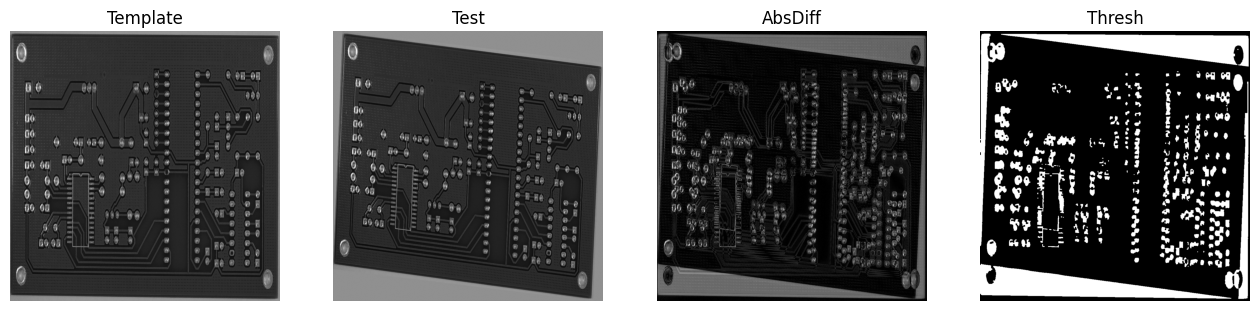

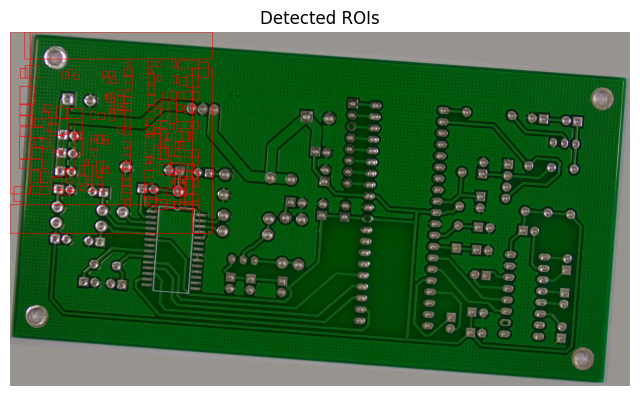

Extracted ROIs: 191


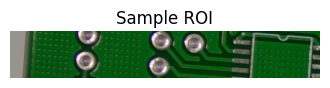

In [13]:
#Run single-pair demo + summary
# run on the selected pair and print/expose results
sel = json.loads(Path("selected_paths.json").read_text())
template_path = Path(sel["template"]); test_path = Path(sel["test"])
diff, mask = preprocess_and_subtract(template_path, test_path, resize_to=(1024,1024), show=True)
rois = extract_rois(test_path, mask, min_area=80, pad=6, show=True)
print("Extracted ROIs:", len(rois))
# Also expose one sample ROI as a preview (optional)
if rois:
    sample = rois[0][1]
    plt.figure(figsize=(4,4)); plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)); plt.title("Sample ROI"); plt.axis("off"); plt.show()


In [ ]:
# Tuning notes
- `resize_to` : (1024,1024) gives consistent boxes. For faster runs use (512,512).
- `min_area`: increase to 150 to ignore small noisy regions; decrease to 30 to capture very small defects.
- morphological kernel size & iterations: increase kernel or close-iterations to merge nearby fragments.
- If images are misaligned: call ECC align function before `absdiff`. (Code for ECC alignment can be added if needed.)


In [ ]:
#What Module 1 does
1. Loads a template image and a corresponding test image (same PCB under inspection).
2. Converts both to grayscale and optionally resizes them.
3. Computes absolute pixel difference to highlight changed regions.
4. Smooths and thresholds the difference with Otsu's method to create a defect mask.
5. Applies morphological close/open to clean mask.
6. Finds connected components (contours) and crops bounding boxes as ROIs for classification in Module 2.
